 ## <center> Итоговый проект "Модель прогнозирования стоимости жилья для агентства недвижимости" ##



 ## Часть 1. Загрузка датасета и первое знакомство с данными. ##

Импортируем нужные библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
# import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

Загрузим и изучим данные

In [2]:
df = pd.read_csv('data/data.zip')
print('Размер набора данных:', df.shape, '\n')
print(df.info(), '\n')
df.head(3)

Размер набора данных: (377185, 18) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null 

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


Итак, у нас есть данные о более чем 370 тысяч объектов на рынке недвижимости, которые описываются 18 признаками.

Условно разделим признаки на  нескольких групп.

**Данные об объекте недвижимости:**
* 'MlsId' - идентификационный номер в системе MLS
* 'mls-id' - идентификационный номер в системе MLS
* 'status' - статус продажи
* 'propertyType' - 'тип' объекта недвижимости

**Характеристики:**
* 'fireplace' - наличие камина
* 'baths' - количество ванных комнат
* 'beds'- количество спальных комнат
* 'private pool' - наличие бассейна
* 'PrivatePool' - наличие бассейна
* 'stories' - количество этажей

**Числовые характеристки:**
* 'sqft' - площадь в квадратных футах

**Географическая информация:**
* 'zipcode' - почтовый индекс
* 'state' - штат
* 'city' - город
* 'street'- адрес

**Прочие признаки (требующие особой предобработки обработки):**
* 'homeFacts'- информация о строительстве объекта
* 'schools' - сведения о школах в районе


**Целевая переменная:** 
* 'target' - цена объекта недвижимости (целевой признак)



 ## Часть 2. Первичная обработка данных. ##

In [3]:
# Проверим наличие повторяющихся строк и удалим их при необходимости.
print(df.duplicated().value_counts())
df = df.drop_duplicates().reset_index(drop=True)

False    377135
True         50
Name: count, dtype: int64


In [261]:
# Посмотрим на пропуски в процентном отношении по каждому признаку
df.isna().sum()/df.shape[0]*100

status          10.584274
private pool    98.891378
propertyType     9.209699
street           0.000530
baths           28.188315
homeFacts        0.000000
fireplace       72.659393
city             0.009015
schools          0.000000
sqft            10.752118
zipcode          0.000000
beds            24.196640
state            0.000000
stories         39.952272
mls-id          93.386453
PrivatePool     89.311520
MlsId           17.730786
target           0.657589
dtype: float64

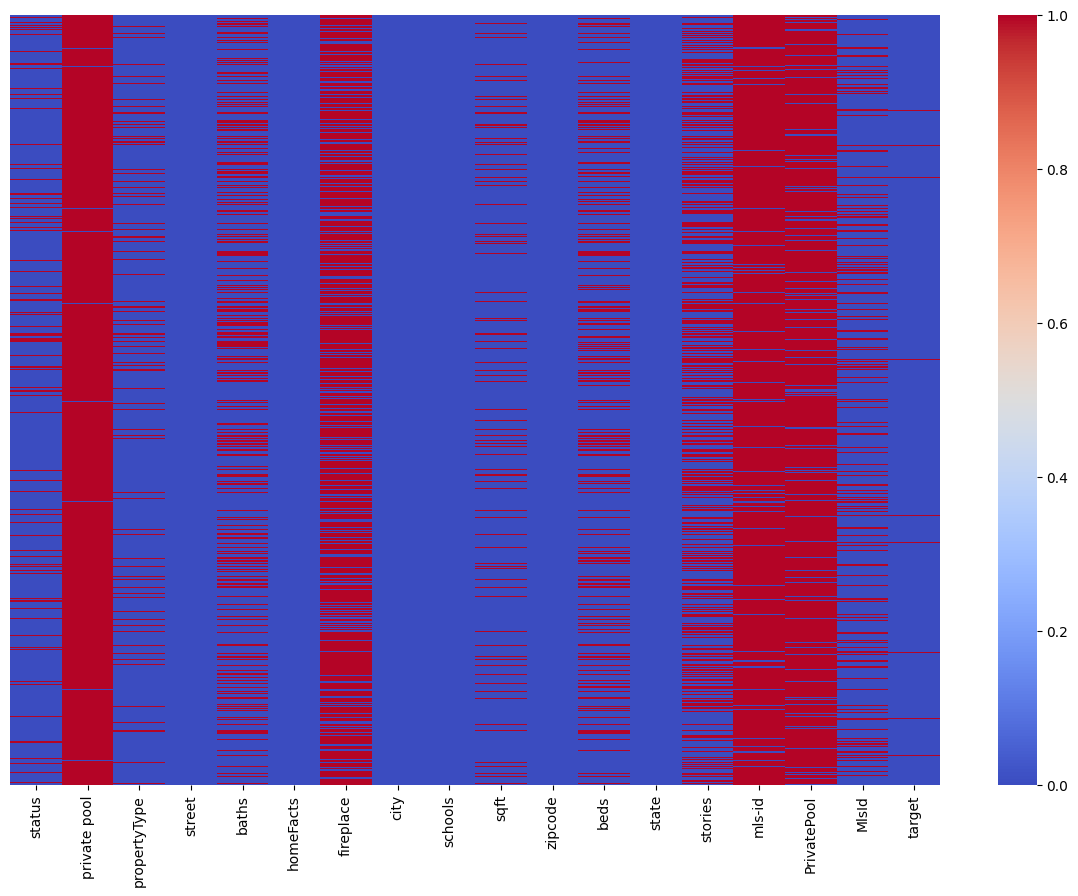

In [262]:
# Визиализируем пропуски
fig, ax = plt.subplots(figsize=(15,10))
sns_heatmap=sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap= 'coolwarm')

Признаки mls-id и MlsId

In [263]:
# Итак можно заметить, что большинство пропусков содержится в столбцах
# private pool и уникальный идентификационный номер объекта. 
# Посмотрим что из себя представляют эти признаки
print(df['mls-id'].nunique())
df[~df['mls-id'].isna()]['mls-id']

24907


13          19221142
20        SR19195113
21         201909438
31          T3159863
38          T3204536
             ...    
377041      14170825
377043        384383
377062    CV19260192
377063       7690588
377122     F10202858
Name: mls-id, Length: 24942, dtype: object

In [264]:
print(df['MlsId'].nunique())
df[~df['MlsId'].isna()]['MlsId']

232944


0             611019
1          201916904
2         FR19221027
3           14191809
4             861745
             ...    
377127      14087883
377129    DCDC444306
377130     A10702700
377131      10374233
377134       1403619
Name: MlsId, Length: 310266, dtype: object

In [265]:
'''Удалим признаки MlsId и mls-id так как во первых в них содержится много пропусков, 
а во вторых идентификационный номер в связи со своей уникальностью
будет бесполезен при построении предсказательной модели'''

df.drop(['MlsId','mls-id'], axis=1, inplace=True)
df.shape

(377135, 16)

Признак private pool и private_pool

In [266]:
'''Посмотрим на признаки указывающие на наличие или отстутсвие бассеина на 
территории объекта недвижимости.
Судя по всему два признака дублируют друг друга.'''

print(df['private pool'].nunique(), '\n')
print(df['private pool'].unique(), '\n')
df[~df['private pool'].isna()]['private pool'].head(3)

1 

[nan 'Yes'] 



205    Yes
321    Yes
355    Yes
Name: private pool, dtype: object

In [267]:
print(df['PrivatePool'].nunique(), '\n')
print(df['PrivatePool'].unique(), '\n')
df[~df['PrivatePool'].isna()]['PrivatePool'].head(3)

2 

[nan 'yes' 'Yes'] 



2     yes
12    yes
19    yes
Name: PrivatePool, dtype: object

In [268]:
# Судя по всему оба признака дублируют друг друга. Объединим их в один бинарный признак.
df['private_pool'] = df[['private pool', 'PrivatePool']].apply(
    lambda x: 0 if (x[0] is np.NaN) and (x[1] is np.NaN) else 1, axis=1
)
df.drop(['private pool', 'PrivatePool'], axis=1, inplace=True )


df.shape

(377135, 15)

Признак baths

In [269]:
''' Обработаем столбцы с числовыми показателями bath и beds, 
которые содержат лишнюю текстовую информацию.'''

print(df['baths'].nunique(), '\n')
print(df['baths'].value_counts(), '\n')

df.loc[~df['baths'].isna(), 'baths'].head(3)

229 

baths
2 Baths       52458
3 Baths       35503
2             20452
2.0           16575
4 Baths       14763
              ...  
4.75 Baths        1
5.25 Baths        1
41.0              1
1.8 Baths         1
44.0              1
Name: count, Length: 229, dtype: int64 



0        3.5
1    3 Baths
2    2 Baths
Name: baths, dtype: object

In [270]:
df.loc[~df['baths'].isna(), 'baths'].str.extract('(\d+)').head()

,0
0,3
1,3
2,2
3,8
8,2


In [271]:
"""Заполним пропущенные значения единицей исходя из предположения, что одна ванна
всё же должна"""
df['baths'] = df['baths'].str.extract('(\d+)')
df['baths'] = df['baths'].fillna(1)

Признак beds

In [272]:

print(df['beds'].nunique(), '\n')
print(df['beds'].value_counts(), '\n')

df.loc[~df['beds'].isna(), 'beds'].head(3)

1184 

beds
3 Beds         53454
4 Beds         35412
3              31405
2 Beds         26355
4              20030
               ...  
8,023 sqft         1
10,193 sqft        1
8.93 acres         1
5,510 sqft         1
8,479 sqft         1
Name: count, Length: 1184, dtype: int64 



0         4
1    3 Beds
2    3 Beds
Name: beds, dtype: object

In [273]:
df['beds'].value_counts().head(10)

beds
3 Beds    53454
4 Beds    35412
3         31405
2 Beds    26355
4         20030
2         16109
Baths     15282
3 bd      12877
5 Beds    11270
4 bd       8265
Name: count, dtype: int64

In [274]:
df.loc[~df['beds'].isna(), 'beds'].str.extract('(\d+)').head(3)

,0
0,4
1,3
2,3


In [275]:
"""Заполним пропущенные значения единицей исходя из предположения, что одна спалня
всё же должна"""
df['beds'] = df['beds'].str.extract('(\d+)')
df['beds'] = df['beds'].fillna('1')
df['beds'].replace('0', '1', inplace=True)

In [276]:
df['beds'].value_counts().head(5)

beds
1    117676
3    105962
4     69091
2     50342
5     22006
Name: count, dtype: int64

Признак fireplace

In [277]:
# Обработаем признак Fireplace
print(df['fireplace'].nunique(), '\n')
print(df['fireplace'].value_counts(), '\n')

df.loc[~df['fireplace'].isna(), 'fireplace'].head(5)

1652 

fireplace
yes                                                                     50353
Yes                                                                     20856
1                                                                       14544
2                                                                        2432
Not Applicable                                                           1993
                                                                        ...  
Free-standing, Insert, Wood                                                 1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter        1
One, Living Room                                                            1
FAMILYRM, Great Room, Living Room                                           1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                     1
Name: count, Length: 1652, dtype: int64 



0     Gas Logs
2          yes
3          yes
18         yes
21         Yes
Name: fireplace, dtype: object

In [278]:
df['fireplace'].isna().sum()

274024

In [279]:
df['fireplace'].fillna(0, inplace=True)

In [280]:
#переводим в бинарный признак (наличие или отсутствия камина)
df['fireplace'] = df['fireplace'].apply(lambda x: 1 if x != 0 else 0)


In [281]:
print(df['fireplace'].value_counts(), '\n')

fireplace
0    274024
1    103111
Name: count, dtype: int64 



Признак stories (количество этажей)

In [282]:
print(df['stories'].nunique(), '\n')
print(df['stories'].value_counts(), '\n')
print(df['stories'].isna().sum(), '\n')

df.loc[~df['stories'].isna(), 'stories'].head(3)

347 

stories
1.0                                  67451
2.0                                  55283
1                                    23085
2                                    18146
3.0                                  11272
                                     ...  
1.2                                      1
Manufactured Home, Non-Site Built        1
Bedroom - Split Plan                     1
78                                       1
65.0                                     1
Name: count, Length: 347, dtype: int64 

150674 



1    2.0
2    1.0
3    3.0
Name: stories, dtype: object

In [283]:
"""Извлечем числовую составляющию признака и заполним пропущенные значения
stories исходя из предположения, что один этаж должен быть"""
df['stories'] = df['stories'].str.extract('(\d+)')
df['stories'] = df['stories'].fillna('1')
df['stories'].replace('0', '1', inplace=True)


In [284]:
df.stories.value_counts().head(5)

stories
1    269504
2     79437
3     17211
9      3386
4      3118
Name: count, dtype: int64

Признак sqft (жилая площадь постройки)

In [285]:
print(df['sqft'].isna().sum(), '\n')

df.loc[~df['sqft'].isna(), 'sqft']

40550 



0               2900
1         1,947 sqft
2         3,000 sqft
3         6,457 sqft
5           897 sqft
             ...    
377129         1,417
377130         4,017
377131    2,000 sqft
377132    1,152 sqft
377134         1,462
Name: sqft, Length: 336585, dtype: object

In [286]:
"""Извлечем числовую составляющию признака, пропущенные значения заполним позже агрегируя
информацию по zipcode"""
df['sqft'] = df['sqft'].str.replace(',','').str.extract('(\d+)')

In [287]:
df.sqft.isna().sum()

41370

Признак target (целевой признак) - стоимость недвижимости в долларах

In [288]:
print(df['target'].isna().sum(), '\n')

df.loc[~df['target'].isna(), 'target'].head(3)

2480 



0      $418,000
1      $310,000
2    $2,895,000
Name: target, dtype: object

In [289]:
"""Извлечем числовую составляющию признака, пропущенные значения заполним позже агрегируя
информацию по zipcode"""
df['target'] = df['target'].str.replace(',','').str.extract('(\d+)')
df.target.isna().sum()

2480

In [290]:
df.loc[~df['target'].isna(), 'target'].head(3)

0     418000
1     310000
2    2895000
Name: target, dtype: object

Признак zipcode

In [291]:
df.zipcode.isna().sum()

0

In [292]:
df.zipcode.value_counts().head(5)

zipcode
32137    2141
33131    1563
34747    1488
78245    1390
34759    1333
Name: count, dtype: int64

In [293]:
df.zipcode.nunique()

4549

Признак state

In [294]:
print(df.state.isna().sum())
print(df.state.nunique())
print(df.state.value_counts())

0
39
state
FL    115434
TX     83780
NY     24474
CA     23385
NC     21854
TN     18339
WA     13820
OH     12587
IL      8938
NV      8482
GA      6701
CO      6404
PA      5561
MI      5161
DC      4673
AZ      3347
IN      3327
OR      2789
MA      1516
UT      1325
MD      1090
VT       868
MO       866
VA       801
WI       452
NJ       436
ME       259
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
Fl         1
BA         1
AL         1
OT         1
OS         1
Name: count, dtype: int64


Признак city

In [295]:
df['city'] = df['city'].str.lower()

In [296]:
df.city.nunique()

1909

In [297]:
df.city.value_counts().head(3)

city
houston        24441
san antonio    15592
miami          15528
Name: count, dtype: int64

In [370]:
df['city'] = df['city'].fillna(df['city'].mode()[0])

Признак street

In [299]:
df.street = df.street.str.lower()
print(df.street.nunique())
print(df['street'].head(3))

336266
0       240 heather ln
1    12911 e heroy ave
2    2005 westridge rd
Name: street, dtype: object


In [300]:
''' Количество уникальных адресов соответствует размеру датасета. Постараемся извлечь максимум информации из этого 
признака постаравшись преобразовать его в категориальнй
'''

def gettingStreet(s, ind):
    s = str(s)
    
    if 'address' in s: return 'no_address'
    elif 'blvd' in s or 'boulevard' in s: return 'boulevard'
    elif 'way' in s: return 'highway'
    elif 'cir' in s: return 'circle'
    elif 'ct' in s or 'court' in s: return 'court'
    elif 'dr' in s or 'drive' in s: return 'drive'
    elif 'rd' in s or 'road' in s: return 'road'
    elif 'ave' in s: return 'avenue'
    elif 'st' in s or 'street' in s: return 'street'
    elif 'pl' in s: return 'place'
    elif 'lane' in s: return 'lane'
    elif 'tr' in s or 'trl' in s or 'trail' in s: return 'trail'
    elif 'park' in s: return 'park'
    else: return 'other'
    
def getting_street_names(df):
  res = pd.DataFrame([
    gettingStreet(string, ind)
    for (string, ind) in zip(df['street'], df.index)
  ])
  return res

In [301]:
dfs = getting_street_names(df)
df.street = dfs
dfs.value_counts()

street        86119
drive         65652
avenue        60698
other         43814
road          43252
court         20013
place         15297
boulevard     13637
highway       12557
circle         8830
trail          4345
no_address     1835
park            747
lane            339
Name: count, dtype: int64

Признак status

In [302]:
df.status = df.status.str.lower()
print(df.status.nunique())
print(df['status'].head(3))

152
0      active
1    for sale
2    for sale
Name: status, dtype: object


In [303]:
df.status.value_counts()[:5]

status
for sale            199524
active              105207
foreclosure           6768
new construction      5474
pending               4807
Name: count, dtype: int64

In [304]:
df.status.isnull().value_counts()

status
False    337218
True      39917
Name: count, dtype: int64

In [305]:
''' Посмотрим на признак статус объекта недвижимости и постараемся подразбить его на категории
'''
def gettingStatus(s, ind):
    s = str(s)
    if 'auction' in s: return 'auction'
    elif 'comin' in s or 'dilige' in s: return 'coming'
    elif 'rent' in s: return 'rent'
    elif 'lease' in s: return 'rent'
    elif 'purch' in s: return 'rent'
    elif 'pend' in s: return 'pending'
    elif 'forec' in s: return 'foreclosure'
    elif 'new' in s: return 'new'
    elif 'contract' in s: return 'contract'
    elif 'continge' in s: return 'contingent'
    elif 'sold' in s or 'closed' in s or 'accept' in s: return 'sold'
    elif 'activ' in s: return 'active'
    elif 'for sale' in s: return 'for sale'
    elif 'backup' in s: return 'contract'
    elif 'back' in s or 'extend' in s: return 'active'
    elif 'continue' in s: return 'active'
    elif s == 'c' or  s == 'ct': return 'contract'
    elif s == 'p': return 'pending'
    elif s == 'ps' or s == 'pf' or s == 'pi': return 'pending'
    elif s == 'nan': return  "no_data"
    else: return s

def getting_status_name(df):
  res = pd.DataFrame([
    gettingStatus(string, ind)
    for (string, ind) in zip(df['status'], df.index)
  ])
  
  return res

stat = getting_status_name(df)
df.status = stat
stat.value_counts()

for sale        199524
active          105909
no_data          39917
foreclosure       9348
pending           6891
new               6164
contract          3848
auction           3070
contingent        1027
price change       563
rent               424
sold               313
coming             137
Name: count, dtype: int64

In [306]:
'''Сразу удалим данные в которых указаны в качестве статуса "аренда", для того, чтобы низкая стоимость по сравнению с продажей не вносила шума в целевую переменную.
'''
df[df.status == 'rent']['target'][:10]

547      5500
609     10500
2075     6390
3025     1200
3645     3600
4613     5500
5515     1200
5873     1250
6837     1200
8167     3250
Name: target, dtype: object

In [307]:
df = df[~(df.status == 'rent')]
df.reset_index(inplace=True, drop=True)

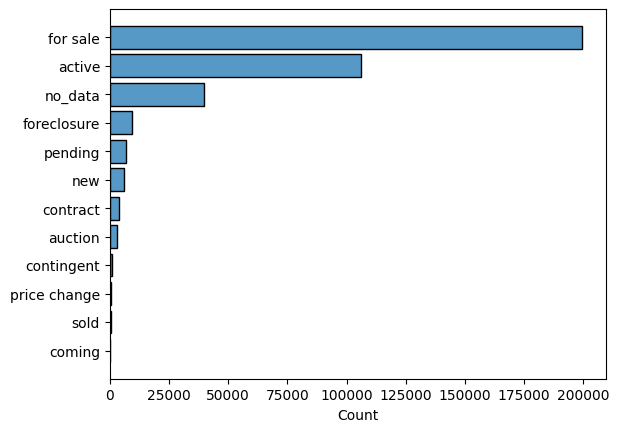

In [308]:
''' Переведем признак status в категориальны и посомтрим на получившиеся категории, как можно увидеть две самые большие категории это недвижимость находящаяся в активной продаже'''
order_list = df.status.value_counts().index.to_list()
df_status = pd.Categorical(df['status'], order_list)
sns.histplot(shrink = 0.8, legend = True, y=df_status);

Признак propertyType

In [309]:
df.propertyType = df.propertyType.str.lower()
print(df.propertyType.nunique())
print(df['propertyType'].head(3))

1272
0    single family home
1    single-family home
2    single-family home
Name: propertyType, dtype: object


In [310]:
df.propertyType.isna().sum()

34733

In [311]:
df.propertyType.value_counts()[:10]

propertyType
single-family home               91982
single family                    62867
condo                            42518
single family home               31717
lot/land                         20526
townhouse                        18345
land                             10934
multi-family                      7789
condo/townhome/row home/co-op     7700
traditional                       5913
Name: count, dtype: int64

In [312]:
''' Постараемся узнать из признака propertyType тип застройки к которому относится объект недвижимости'''

def getting_type(s, ind):
    s = str(s)
    if 'single' in s or 'traditional' in s: return 'single'
    elif 'condo' in s or 'flat' in s: return 'flat'
    elif 'townh' in s: return 'townhouse'
    elif 'coop' in s or 'co-op' in s: return 'coop'
    elif 'land' in s: return 'land'
    elif 'multi' in s: return 'multi'
    elif 'contempo' in s: return 'contemporary'
    elif 'mobi' in s or 'carri' in s: return 'mobile'
    elif 'two' in s or '2' in s: return 'two story'
    elif 'one' in s or '1' in s: return 'one story'
    elif 'storie' in s in s: return 'multy-story'
    elif 'deta' in s or 'deta' in s: return 'detached'
    elif 'rise' in s or 'unit' in s or 'high' in s: return 'flat'
    elif 'pent' in s: return 'penthouse'
    elif 'ran' in s: return 'ranch'
    elif 'gard' in s: return 'garden'
    elif 'cust' in s or 'manuf' in s or 'craft' in s: return 'custom'
    elif 'atta' in s or 'plex' in s: return 'attached'
    elif 'farm' in s: return 'farm'
    elif 'level' in s: return 'split-level'
    elif 'other' in s: return 'other'
    elif 'colo' in s: return 'colonial'
    elif 'ware' in s or 'com' in s: return 'commercial'
    elif 'cott' in s or 'resid' in s or 'court' in s: return 'cottage'
    elif 'boat' in s: return 'boathouse'
    elif s == 'nan' or s == '': return 'other'
    else: return 'other'

def getting_type_name(df):
  res = pd.DataFrame([
    getting_type(string, ind)
    for (string, ind) in zip(df['propertyType'], df.index)
  ])
  return res

pt = getting_type_name(df)
df['propertyType'] = pt
df.propertyType.isna().sum()

0

In [313]:
df.propertyType.value_counts()

propertyType
single          198087
flat             52993
other            39200
land             31468
townhouse        18520
multi            12364
one story         4227
coop              3839
mobile            3521
ranch             3472
contemporary      3383
two story         2524
colonial          1260
custom             485
garden             358
split-level        346
attached           166
detached           157
cottage             84
penthouse           79
farm                79
multy-story         76
commercial          19
boathouse            4
Name: count, dtype: int64

In [314]:
''' С целью невилирования лишнего шума удалим информацию относящуюся к  коммерческой недвижимости'''
df = df[~((df['propertyType'] == 'farm') | (df['propertyType'] == 'boathouse') | (df['propertyType'] == 'commercial') ) ]
df.reset_index(inplace=True, drop=True)

Признак homeFacts

In [315]:
''' При первом взгляде на данный признакам можно заметить, что он представляет из себя словарь по типу JSON. И судя по его структуре в этом признаке содержится информация о :
1. Годе постройки
2. Годе ремонта
3. Тип отопления
4. Система кондитирования
5. Тип парковочного места
6. Размер земелного участка
7. Цена за квадратный метра (в дальнейшем для избежения data leakage мы уберем этот признак из дата сета, однако 
воспользуемся им чтобы посомтреть на среднию цену за квадратный метр по географическуму признаку zipcode'''
ast.literal_eval(df.loc[3, 'homeFacts'])

{'atAGlanceFacts': [{'factValue': '2006', 'factLabel': 'Year built'},
  {'factValue': '2006', 'factLabel': 'Remodeled year'},
  {'factValue': 'Forced Air', 'factLabel': 'Heating'},
  {'factValue': 'Central', 'factLabel': 'Cooling'},
  {'factValue': 'Detached Garage', 'factLabel': 'Parking'},
  {'factValue': '8,220 sqft', 'factLabel': 'lotsize'},
  {'factValue': '$371/sqft', 'factLabel': 'Price/sqft'}]}

In [316]:
''' Теперь извлечем информацию из столбца homeFacts. После преобразования количество признаков 
увеличилось до 21'''

def getting_home(string):
    facts_list = ast.literal_eval(string)['atAGlanceFacts']
    return (
        facts_list[0]['factValue'],
        facts_list[1]['factValue'],
        facts_list[2]['factValue'],
        facts_list[3]['factValue'],
        facts_list[4]['factValue'],
        facts_list[5]['factValue'],
        facts_list[6]['factValue']
    )

(
    df['year_built'],
    df['year_remodeled'],
    df['heating'],
    df['cooling'],
    df['parking'],
    df['lot_size'],
    df['price_sqft']
) = zip(*df['homeFacts'].apply(getting_home))

df = df.drop(['homeFacts'], axis=1)

print(df.shape)

(376609, 21)


Признак schools

In [317]:
''' При первом взгляде на признак schools можно заметить, что он представляет из себя словарь по типу JSON. И судя по его структуре в этом признаке содержится информация о :
1. Рейтинге школы по 10-ти бальной системе
2. Растоянии  от объекта недвижимости до школы
3. Типе школы (pre-school, middle, high school) эту информацию мы не будем включать в датасет
4. название школы. Из этого информации мы так же не будет сосздавать признак'''
ast.literal_eval(df.loc[3, 'schools'])

[{'rating': ['9/10', '9/10', '10/10', '9/10'],
  'data': {'Distance': ['1.05mi', '0.1mi', '1.05mi', '0.81mi'],
   'Grades': ['5-6', 'PK-4', '7-8', '9-12']},
  'name': ['Mcculloch Intermediate School',
   'Bradfield Elementary School',
   'Highland Park Middle School',
   'Highland Park High School']}]

In [318]:
''' Теперь извлечем информацию из столбца schools. После преобразования количество признаков 
увеличилось до 22'''

def getting_school(string):
    school_dict = ast.literal_eval(string)
    rates = list()
    for rate in school_dict[0]['rating']:
         if rate == 'NR':
           rates.append(0)
         else:
           if rate.split('/')[0] in ('None', 'NR', 'NA', ''):
              rates.append(0)
           else:
              rates.append(int(rate.split('/')[0]))
    distances = list()
    for distance in school_dict[0]['data']['Distance']:
        distances.append(float(distance[:-2]))
    grades = list()
    return (np.mean(rates),
            np.mean(distances)
           )

(
  df['school_rate_mean'], 
  df['school_distance_mean']
) = zip(*df['schools'].apply(getting_school))

df = df.drop(['schools'], axis=1)

print(df.shape)

(376609, 22)


Признак heating (homeFacts №1)

In [319]:
''' Посмотрим что из себя представляет этот признак'''
print(df.heating.nunique())
df.heating.str.lower().str.strip().value_counts(dropna=False).head(10)


1969


heating
forced air          134296
                    105460
other                29611
electric             10213
gas                   9291
heat pump             8851
no data               8610
central air           7814
central electric      7111
central               6247
Name: count, dtype: int64

In [320]:
df.heating = df.heating.str.lower().str.strip()
df['heating'] = df['heating'].fillna('no heat')

In [321]:
'''Сделаем признак категориальным сократив количество уникальных значений'''
def getting_heating(s, ind):
    s = str(s)
    
    if 'no heat' in s or s == '': return 'no_heat'
    elif 'central' in s : return 'central'
    elif 'no data' in s or 'no' in s: return 'no_heat'
    elif 'other' in s: return 'other'
    elif 'forced air' in s : return 'forced_air'
    elif 'electric' in s: return 'electric'
    elif 'gas' in s: return 'gas'
    elif 'heat' in s: return 'heat'
    else: return 'other'
    
def list_heating(df):
  res = pd.DataFrame([
    getting_heating(string, ind)
    for (string, ind) in zip(df['heating'], df.index)
  ])
  return res

dfh = list_heating(df)
df['heating'] = dfh

Признак cooling (homeFacts №2)

In [322]:
''' Посмотрим что из себя представляет этот признак'''
print(df.cooling.nunique())
df.cooling.str.lower().str.strip().value_counts(dropna=False).head(10)

1431


cooling
central             158734
                    119944
central air          14383
no data              10615
has cooling           9730
none                  7390
central electric      6151
wall                  4016
central gas           3573
None                  3533
Name: count, dtype: int64

In [323]:
df.cooling = df.cooling.str.lower().str.strip()
df['cooling'] = df['cooling'].fillna('no cool')

In [324]:
''' Аналогично разберемся со столбцом cooling, только переведем его в бинарный признак так как судя по всему категории
в этом признаке практически дублируют категории признака heating.'''
def getting_cooling(s):
    s = str(s)
    if 'no cool' in s or s == '': return 0
    elif 'central air' in s  : return 1
    elif 'no data' in s or 'no' in s: return 0
    elif 'cooling' in s or 'system': return 1
    elif 'a/c' in s or 'refrigeration' : return 1
    else: return 0

dfc = df['cooling'].apply(getting_cooling)
df['cooling'] = dfc

In [325]:
df['cooling'].value_counts(dropna=False)

cooling
1    234849
0    141760
Name: count, dtype: int64

Признак parking (homeFacts №3)

In [326]:
''' Посмотрим что из себя представляет этот признак'''
print(df.parking.nunique())
df.parking.str.lower().str.strip().value_counts(dropna=False).head(10)

3343


parking
                   171535
attached garage     70748
2 spaces            28059
1 space             14245
no data             13333
detached garage     13199
carport              7742
off street           5239
3 spaces             4724
None                 3533
Name: count, dtype: int64

In [327]:
df['parking'] = df['parking'].str.lower()
df['parking'] = df['parking'].fillna('no parking')

In [328]:
'''Из признаков parking cоздадим два бинарных признака: наличие парковки, наличие гаража и так же числовой признак количество парковочных мест'''

df['has_parking'] = df['parking'].apply(lambda x: 0 if x.strip() in ('', 'no data', 'none', 'no parking', 'no') else 1)
df['garage'] = df['parking'].apply(lambda x: 1 if 'garage' in x else 0)
df['parking_spaces'] = df['parking'].str.extract('(\d+)')
df['parking_spaces'] = df['parking_spaces'].fillna(0)

df = df.drop(['parking'], axis=1)

Признак year_built и year_remodeled (homeFacts)

In [329]:
print(df.year_built.isna().sum())
df.year_built.value_counts(dropna=False).head(3)

3606


year_built
        58691
2019    32138
2006     7998
Name: count, dtype: int64

In [330]:
print(df.year_remodeled.isna().sum())
df.year_remodeled.value_counts(dropna=False).head(3)

26563


year_remodeled
        198991
None     26563
2006      5538
Name: count, dtype: int64

In [333]:
maskb = df['year_built'].isna()
df.loc[~maskb, 'year_built'] = df[~maskb]['year_built'].apply(lambda x: np.NaN if x.strip().lower() == 'no data' else x)
df['year_built'] = df['year_built'].apply(lambda x: np.NaN if x == '' else x)

maskr = df['year_remodeled'].isna()
df.loc[~maskr, 'year_remodeled'] = df[~maskr]['year_remodeled'].apply(lambda x: np.NaN if x.strip().lower() == 'no data' else x)
df['year_remodeled'] = df['year_remodeled'].apply(lambda x: np.NaN if x == '' else x)

df['year_built'] = df['year_built'].astype('float')
df['year_remodeled'] = df['year_remodeled'].astype('float')
year_built_zipcode = df[~maskb].groupby(by=['zipcode']).agg({'year_built' : ['count', 'mean']})
year_rebuilt_zipcode = df[~maskr].groupby(by=['zipcode']).agg({'year_remodeled' : ['count', 'mean']})

for zipcode in year_built_zipcode.index:
    mask = df['zipcode'] == zipcode
    if year_built_zipcode.loc[zipcode, ('year_built', 'count')] > 2:
        df.loc[maskb&mask, 'year_built'] = year_built_zipcode.loc[zipcode, ('year_built', 'mean')]
        
for zipcode in year_rebuilt_zipcode.index:
    mask = df['zipcode'] == zipcode
    if year_rebuilt_zipcode.loc[zipcode, ('year_remodeled', 'count')] > 2:
        df.loc[maskb&mask, 'year_built'] = year_rebuilt_zipcode.loc[zipcode, ('year_remodeled', 'mean')]

df['year_remodeled'] = df['year_remodeled'].fillna(df['year_remodeled'].mode()[0])
df['year_built'] = df['year_built'].fillna(df['year_built'].mode()[0])

In [341]:
df.year_remodeled.isna().sum()
df.year_built.isna().sum()

0

In [391]:
# df['year_built'] = df['year_built'].astype('float')
# df['year_remodeled'] = df['year_built'].astype('float')

Признак sqft (заполнение пропусков)

In [342]:
df.sqft.value_counts()

sqft
0         11854
1200       1420
1000       1021
1500       1014
1800        984
          ...  
18356         1
476           1
100000        1
435164        1
13870         1
Name: count, Length: 9895, dtype: int64

In [343]:
df.sqft.isna().sum()

41332

In [344]:
df['sqft'] = df['sqft'].apply(lambda x: np.NaN if x == '' or x == '0' else x)
df['sqft'] = df['sqft'].astype(float)
mask = df['sqft'].isna()
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'sqft' : ['count', 'mean']})


mask1 = df['sqft'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('sqft', 'count')] > 2:
        df.loc[mask1&mask2, 'sqft'] = year_zipcode.loc[zipcode, ('sqft', 'mean')]

df['sqft'] = df['sqft'].fillna(df['sqft'].mode()[0])


In [350]:
df.sqft.isna().sum()

0

Признак lot_size (homeFacts)

In [355]:
''' Посмотрим что из себя представляет этот признак'''
print(df.lot_size.isna().sum())

df.lot_size.value_counts(dropna=True)

28378


lot_size
                  32650
—                 25206
No Data            5329
-- sqft lot        3819
0.26 acres         2511
                  ...  
407 sqft              1
7,489 sqft            1
3140                  1
113169                1
7,084 sqft lot        1
Name: count, Length: 37386, dtype: int64

In [401]:
# df['lot_size'] = df['lot_size'].str.replace(',','').str.extract('(\d+)')

In [402]:
# df.lot_size.isna().sum()

95841

In [356]:
# df['lot_size'] = df['lot_size'].apply(lambda x: np.NaN if x == '' else x)
# df['lot_size'] = df['lot_size'].str.replace(',','').str.extract('(\d+)')
df['lot_size'] = df['lot_size'].str.replace(',','').str.extract('(\d+)')
df['lot_size'] = df['lot_size'].astype(float)

mask = df['lot_size'].isna()
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'lot_size' : ['count', 'mean']})
# year_state = df[~mask].groupby(by=['state']).agg({'lot_size' : ['count', 'mean']})

mask1 = df['lot_size'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('lot_size', 'count')] > 2:
        df.loc[mask1&mask2, 'lot_size'] = year_zipcode.loc[zipcode, ('lot_size', 'mean')]

# for state in year_state.index:
#     mask2 = df['state'] == state
#     df.loc[mask1&mask2, 'lot_size'] = year_state.loc[state, ('lot_size', 'mean')]

In [358]:
df['lot_size'] = df['lot_size'].fillna(df['lot_size'].mode()[0])

In [359]:
df.lot_size.isna().sum()

0

Признак price_sqft (homeFacts)

In [360]:
''' Посмотрим что из себя представляет этот признак'''
print(df.price_sqft.isna().sum())

df.price_sqft.value_counts()

58109


price_sqft
                    5185
No Data             1241
$1/sqft              974
No Info              954
$125/sqft            797
                    ... 
$10714 / Sq. Ft.       1
$1104 / Sq. Ft.        1
$3,077/sqft            1
$2,244/sqft            1
$2,032                 1
Name: count, Length: 6502, dtype: int64

In [361]:
df['price_sqft'] = df['price_sqft'].str.replace(',','').str.extract('(\d+)')
df['price_sqft'] = df['price_sqft'].apply(lambda x: np.NaN if x == '' or x == '0' else x)
df['price_sqft'] = df['price_sqft'].astype(float)
mask = df['price_sqft'].isna()
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'price_sqft' : ['count', 'mean']})
# year_state = df[~mask].groupby(by=['state']).agg({'price_sqft' : ['count', 'mean']})

mask1 = df['price_sqft'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('price_sqft', 'count')] > 4:
        df.loc[mask1&mask2, 'price_sqft'] = year_zipcode.loc[zipcode, ('price_sqft', 'mean')]

# for state in year_state.index:
#     mask2 = df['state'] == state
#     df.loc[mask1&mask2, 'price_sqft'] = year_state.loc[state, ('price_sqft', 'mean')]

df['price_sqft'] = df['price_sqft'].fillna(df['price_sqft'].mode()[0])

In [362]:
df['price_sqft'].isna().sum()

0

Признак school_rate_mean (заполнение пропусков)

In [364]:
mask = df['school_rate_mean'].isna()
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'school_rate_mean' : ['count', 'mean']})
# year_state = df[~mask].groupby(by=['state']).agg({'school_rate_mean' : ['count', 'mean']})

mask1 = df['school_rate_mean'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('school_rate_mean', 'count')] > 2:
        df.loc[mask1&mask2, 'school_rate_mean'] = year_zipcode.loc[zipcode, ('school_rate_mean', 'mean')]

# for state in year_state.index:
#     mask2 = df['state'] == state
#     df.loc[mask1&mask2, 'school_rate_mean'] = year_state.loc[state, ('school_rate_mean', 'mean')]

df['school_rate_mean'] = df['school_rate_mean'].fillna(df['school_rate_mean'].mode()[0])

Признак school_distance_mean (заполнение пропусков)

In [365]:
mask = df['school_distance_mean'].isna()
year_zipcode = df[~mask].groupby(by=['zipcode']).agg({'school_distance_mean' : ['count', 'mean']})
# year_state = df[~mask].groupby(by=['state']).agg({'school_distance_mean' : ['count', 'mean']})

mask1 = df['school_distance_mean'].isna()
for zipcode in year_zipcode.index:
    mask2 = df['zipcode'] == zipcode
    if year_zipcode.loc[zipcode, ('school_distance_mean', 'count')] > 4:
        df.loc[mask1&mask2, 'school_distance_mean'] = year_zipcode.loc[zipcode, ('school_distance_mean', 'mean')]

# for state in year_state.index:
#     mask2 = df['state'] == state
#     df.loc[mask1&mask2, 'school_distance_mean'] = year_state.loc[state, ('school_distance_mean', 'mean')]

df['school_distance_mean'] = df['school_distance_mean'].fillna(df['school_distance_mean'].mode()[0])

Признак target (целевой признак)

In [366]:
df.target.isna().sum()

2480

In [367]:
mask = df['target'].isna()
df.loc[mask, 'target'] = df[mask][['price_sqft', 'sqft']].apply(
    lambda x: x[0]*x[1] if x[0] is not np.NaN and x[1] is not np.NaN else np.NaN, axis=1
)

In [368]:
df['target'].isna().sum()

0

 ## Часть 3. Финальная очистка датасета. ##

In [372]:
'''Проверим получившийся датасет на пропуски'''
df.isna().sum()

status                  0
propertyType            0
street                  0
baths                   0
fireplace               0
city                    0
sqft                    0
zipcode                 0
beds                    0
state                   0
stories                 0
target                  0
private_pool            0
year_built              0
year_remodeled          0
heating                 0
cooling                 0
lot_size                0
price_sqft              0
school_rate_mean        0
school_distance_mean    0
has_parking             0
garage                  0
parking_spaces          0
dtype: int64

In [375]:
df.dtypes

status                   object
propertyType             object
street                   object
baths                    object
fireplace                 int64
city                     object
sqft                    float64
zipcode                  object
beds                     object
state                    object
stories                  object
target                   object
private_pool              int64
year_built              float64
year_remodeled          float64
heating                  object
cooling                   int64
lot_size                float64
price_sqft              float64
school_rate_mean        float64
school_distance_mean    float64
has_parking               int64
garage                    int64
parking_spaces           object
dtype: object

In [376]:
'''Приведем признаки к соответствующим типам данных'''
df['baths'] = df['baths'].astype(int)
df['fireplace'] = df['fireplace'].astype(int)
df['beds'] = df['beds'].astype(int)
df['cooling'] = df['cooling'].astype(int)
df['stories'] = df['stories'].astype(int)
df['target'] = df['target'].astype(float)
df['year_built'] = df['year_built'].astype(int)
df['year_remodeled'] = df['year_remodeled'].astype(float).astype(int)
df['parking_spaces'] = df['parking_spaces'].astype(int)

In [377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376609 entries, 0 to 376608
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                376609 non-null  object 
 1   propertyType          376609 non-null  object 
 2   street                376609 non-null  object 
 3   baths                 376609 non-null  int32  
 4   fireplace             376609 non-null  int32  
 5   city                  376609 non-null  object 
 6   sqft                  376609 non-null  float64
 7   zipcode               376609 non-null  object 
 8   beds                  376609 non-null  int32  
 9   state                 376609 non-null  object 
 10  stories               376609 non-null  int32  
 11  target                376609 non-null  float64
 12  private_pool          376609 non-null  int64  
 13  year_built            376609 non-null  int32  
 14  year_remodeled        376609 non-null  int32  
 15  

Для последующей работы сохраним датафрейм в отдельный файл 

In [378]:
df.to_pickle('data/df_for_eda_i2.pickle')